In [0]:
!git clone https://github.com/Aelhanchi/torch_vr.git

In [0]:
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch
import torchvision

import os
os.chdir('./torch_vr')
from torch_vr.prev_grads import PrevGrads
from torch_vr.reduce_var import ReduceVar

In [0]:
# uses GPU
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [0]:
# Loads the MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=False, 
                                   transform=torchvision.transforms.ToTensor)
X = mnist.data.flatten(1)/255.0
U,_,_ = torch.svd(X.t())
X = (X @ U[:,:100]).to('cuda')
y = mnist.targets.to('cuda')
N = X.shape[0]
d_in = 100
d_out = 9

In [0]:
# defines the model
torch.manual_seed(0)
class Softmax_regression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(d_in, d_out, bias=True)
        
        self.A0 = None
        self.Z1 = None
        self.A1 = None

    def forward(self, X):
        self.A0 = X
        self.Z1 = self.lin(self.A0)
        self.Z1.retain_grad()
        self.A1 = torch.nn.functional.log_softmax(self.Z1, dim=1)
        return torch.cat([self.A1, torch.zeros_like(self.A1[:,0:1])], dim=1)
    
# defines the loss and initializes the model
loss_func = torch.nn.NLLLoss(reduction='sum')
model = Softmax_regression()

In [7]:
# Gets close to the optimum where the variance reduction effect is clear
iterations = 2000
batch_size = 1024
opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=1)
losses_SGD = list()

for i in tqdm(range(iterations)):
    opt.zero_grad()
    indices = np.random.choice(N, batch_size, replace=False)
    loss = loss_func(model(X[indices]), y[indices])
    loss.backward()
    for p in model.parameters():
        p.grad *= N/batch_size
    with torch.no_grad():
        losses_SGD.append(loss_func(model(X), y))
    opt.step()

# caches the starting point
start = copy.deepcopy(model.state_dict())

In [9]:
# trains the model using SGD
model.load_state_dict(start)
iterations = 1000
batch_size = 1024
opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=1)
losses_SGD = list()

for i in tqdm(range(iterations)):
    opt.zero_grad()
    #indices = torch.multinomial(torch.ones(N), batch_size, replacement=False)
    indices = np.random.choice(N, batch_size, replace=False)
    loss = loss_func(model(X[indices]), y[indices])
    loss.backward()
    for p in model.parameters():
        p.grad *= N/batch_size
    with torch.no_grad():
        #losses_SGD.append(loss.detach_())
        losses_SGD.append(loss_func(model(X), y))
    opt.step()

In [10]:
# trains the model using SAG
model.load_state_dict(start)
iterations = 1000
batch_size = 1024
opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=1)
losses_SAG = list()
var_reducer = ReduceVar(model.parameters(), N, [model.lin], method='SAG')

for i in tqdm(range(iterations)):
    opt.zero_grad()
    #indices = var_reducer.sample_indices(batch_size)
    indices = np.random.choice(N, batch_size, replace=False)
    loss = loss_func(model(X[indices]), y[indices])
    loss.backward()
    var_reducer.reduce_variance([model.Z1.grad], [model.A0], indices)
    with torch.no_grad():
        #losses_SAG.append(loss.detach_())        
        losses_SAG.append(loss_func(model(X), y))
    opt.step()

In [11]:
# trains the model using SAGA
model.load_state_dict(start)
iterations = 1000
batch_size = 1024
opt = torch.optim.SGD(model.parameters(), lr=1e-05, weight_decay=1)
losses_SAGA = list()
var_reducer = ReduceVar(model.parameters(), N, [model.lin], method='SAGA')

for i in tqdm(range(iterations)):
    opt.zero_grad()
    #indices = var_reducer.sample_indices(batch_size)
    indices = np.random.choice(N, batch_size, replace=False)
    loss = loss_func(model(X[indices]), y[indices])
    loss.backward()
    var_reducer.reduce_variance([model.Z1.grad], [model.A0], indices)    
    with torch.no_grad():
        #losses_SAGA.append(loss.detach_())        
        losses_SAGA.append(loss_func(model(X), y))    
    opt.step()

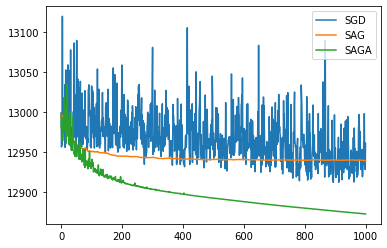

In [16]:
# plots the progress of each of SGD, SAGA, and SAG
plt.plot(losses_SGD, label='SGD')
plt.plot(losses_SAG, label='SAG')
plt.plot(losses_SAGA, label='SAGA')
plt.legend(loc="upper right");